In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [2]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

#### 2. Sample the `graph`

In [21]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':0,'NO2':10}
    )

t = Traversal(graph=graph)


data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

1008it [00:56, 17.80it/s]                         


#### 3. generate reaction statistics

In [18]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(20)

1 H2O + 1 SO2 = 1 H2SO3                   321
1 H2 + 1 SO2 = 1 O2 + 1 H2S               318
1 H2SO4 + 1 N2 = 1 H2S + 2 NO2            273
2 H2 + 1 O2 = 2 H2O                       248
1 O2 + 1 H2S + 2 NO2 = 1 SO2 + 2 HNO2     210
2 O2 + 1 H2S = 1 H2SO4                    194
3 H2 + 1 SO2 = 2 H2O + 1 H2S              154
3 O2 + 2 H2S = 2 H2O + 2 SO2              151
1 H2 + 1 NO2 = 1 H2O + 1 NO               138
8 H2O + 1 S8 = 2 H2SO4 + 6 H2S            116
1 H2O + 1 SO2 + 1 NO2 = 1 H2SO4 + 1 NO    115
1 H2O + 1 NO2 + 1 NO = 2 HNO2             103
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO      99
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2             91
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4              84
1 H2 + 1 SO2 + 2 NO = 1 H2SO4 + 1 N2       80
1 S8 + 8 NO2 = 8 SO2 + 4 N2                79
16 H2O + 3 S8 = 16 H2S + 8 SO2             72
2 H2 + 2 SO2 + 1 N2 = 2 H2S + 2 NO2        71
1 H2 + 1 H2SO4 = 1 H2O + 1 H2SO3           67
dtype: int64

#### 4. generate mean concentrations and differences

In [ ]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

        initial   mean  diff   sem   std    var
H2S        10.0   4.34 -5.66  0.06  3.79  14.33
NO2        10.0   4.37 -5.63  0.08  4.85  23.50
O2         10.0   4.74 -5.26  0.08  4.95  24.52
H2O        30.0  27.64 -2.36  0.08  5.31  28.20
S8          0.0   0.00  0.00  0.00  0.00   0.00
NH3         0.0   0.16  0.16  0.01  0.85   0.72
NOHSO4      0.0   0.19  0.19  0.01  0.92   0.85
HNO3        0.0   0.38  0.38  0.02  1.36   1.84
SO2        10.0  10.60  0.60  0.09  5.66  32.01
NO          0.0   0.87  0.87  0.04  2.64   6.96
HNO2        0.0   1.28  1.28  0.05  3.08   9.47
N2          0.0   1.38  1.38  0.03  2.19   4.78
H2          0.0   1.99  1.99  0.06  3.73  13.93
H2SO3       0.0   2.04  2.04  0.06  3.98  15.83
H2SO4       0.0   2.84  2.84  0.06  3.89  15.14


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_71384/949321809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name='RdBu')  # or any other colormap


<Axes: >

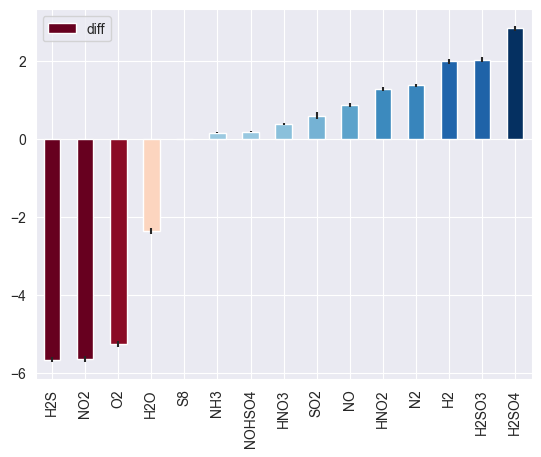

In [20]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [16]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white','directed':True}
g = analysis.result_to_pyvis(data,head=20,**pyvis_kwargs)
g.save_graph(name="example_pyvis_graph.html")

In [37]:
! open example_pyvis_graph.html